## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.callbacks import TensorBoard

Using TensorFlow backend.


## Configuration

In [3]:
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
K.tensorflow_backend.set_session(tf.Session(config=config))

state_size=512
embedding_size=200
factored_size=512
layer_size=1
injection_mode='pre'
learning_rate=0.0002
beta_1=0.9
beta_2=0.999
epsilon=1e-08
lstm_layers=1
batch_size=64

## Load Data

path format :
    - /img/ -- contain images
    - /cache/ -- contain cache
    - /captions.json -- contain all captions data
    - /factual
        - /captions.json -- only contain list of list captions
        - /filenames.json -- list of filenames
        - train.txt -- indexes for train
        - val.txt -- indexes for validation
        - test.txt -- indexes for test

format captions.json (all captions data version):
    - {
        'image_id': 331-flickr,
        'filename': 000123.jpg,
        'captions': [
            {'id': 'Bahasa Indonesia',
             'en' : 'English'},
            ...
        ],
        'emotions': {
            'happy': 'Emosi happy',
            'sad': 'Emosi sad',
            'angry': 'Emosi angry'
        }
      }

In [5]:
from preprocess.dataset import invoke_emotion_to_dataset, invoke_edited_to_dataset, load_caption

path = './dataset'
flickr_folder = path + '/flickr10k'

all_filenames = {
    'factual': [],
    'happy': [],
    'sad': [],
    'angry': []
}
all_captions = {
    'factual': [],
    'happy': [],
    'sad': [],
    'angry': []
}

modes = ['happy', 'sad', 'angry']
captions = []
filenames = []
for mode in modes + ['factual']:
    train, val, test = load_caption(flickr_folder + '/' + mode)
    filenames_train, captions_train = train
    filenames_val, captions_val = val
    filenames_test, captions_test = test
    if mode == 'factual':
        filenames += filenames_train + filenames_val + filenames_test
    captions += captions_train + captions_val + captions_test

# for test only
filenames_train, captions_train = filenames_train[:50], captions_train[:50]
filenames_val, captions_val = filenames_val[50:55], captions_val[50:55]
filenames_test, captions_test = filenames_test[55:60], captions_test[55:60]

num_images_train = len(filenames_train)
num_images_train

50

### Loading and Showing Images

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from preprocess.images import load_image

In [9]:
def show_image(idx, folder_path, captions, filenames):

    filename = filenames[idx]
    captions = captions[idx]

    path = folder_path + '/img/' + filename

    for caption in captions:
        print(caption)

    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example Image

Laki-laki Kaukasia dengan kaos hitam dan celana pendek kargo yang memandang gunung-gunung yang jauh dan badan air.
Seorang pria dengan anjingnya mengenakan peralatan mendaki dan melihat pemandangan pegunungan.
Seorang pria dengan anjingnya di luar di hutan pada waktu musim panas dengan ransel.
Seorang pria berbaju hitam dan celana pendek dan anjing di luar.
Manusia di gunung melihat ke bawah di danau.


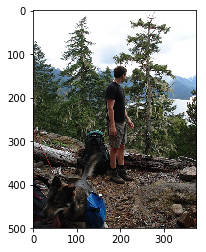

In [10]:
show_image(idx=0, folder_path=flickr_folder, captions=captions_test, filenames=filenames_test)

## Pre-Trained Image Model (ResNet152)

In [11]:
from model import EncoderResNet152
from keras import backend as K
encoder_resnet152 = EncoderResNet152()

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
img_size = K.int_shape(encoder_resnet152.model.input)[1:3]
transfer_values_size = K.int_shape(encoder_resnet152.model.output)[1]
print('img_size', img_size)
print('transfer_values_size', transfer_values_size)

img_size (224, 224)
transfer_values_size 2048


## Load pretrained image

In [16]:
from preprocess.images import process_images_all

In [17]:
%%time
transfer_values = process_images_all(folder_path=flickr_folder,
                                     filenames=filenames,
                                     img_size=img_size,
                                     transfer_values_size=transfer_values_size,
                                     image_model_transfer=encoder_resnet152.model,
                                     batch_size=64)
print(len(transfer_values))

Processing 10000 images ...
10000
CPU times: user 76 ms, sys: 40.8 ms, total: 117 ms
Wall time: 124 ms


## Tokenizer

In [19]:
from preprocess.tokenizer import mark_captions, flatten, TokenizerWrap, mark_start, mark_end

In [20]:
%%time
captions_marked = mark_captions(captions)
captions_flat = flatten(captions_marked)
tokenizer = TokenizerWrap(texts=captions_flat)
num_words = len(tokenizer.word_index)
print(num_words)

11472
CPU times: user 1.02 s, sys: 14.4 ms, total: 1.03 s
Wall time: 1.04 s


In [21]:
%%time
captions_train_marked = mark_captions(captions_train)
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 3.89 ms, sys: 6 µs, total: 3.89 ms
Wall time: 3.9 ms


In [22]:
%%time
captions_val_marked = mark_captions(captions_val)
tokens_val = tokenizer.captions_to_tokens(captions_val_marked)

CPU times: user 581 µs, sys: 1e+03 ns, total: 582 µs
Wall time: 588 µs


In [23]:
%%time
captions_test_marked = mark_captions(captions_test)
tokens_test = tokenizer.captions_to_tokens(captions_test_marked)

CPU times: user 650 µs, sys: 4 µs, total: 654 µs
Wall time: 659 µs


In [24]:
token_start = tokenizer.word_index[mark_start.strip()]
token_end = tokenizer.word_index[mark_end.strip()]
print('token_start', token_start)
print('token_end', token_end)

token_start 1
token_end 2


In [25]:
import numpy as np
transfer_values_train = np.array(
    [transfer_values[filename] for filename in filenames_train])
transfer_values_val = np.array(
    [transfer_values[filename] for filename in filenames_val])
transfer_values_test = np.array(
    [transfer_values[filename] for filename in filenames_test])

## Data Generator

In [27]:
from utils.generator import batch_generator

In [28]:
batch_size = 2

In [29]:
generator_train = batch_generator(batch_size=batch_size,
                                  transfer_values=transfer_values_train,
                                  tokens=tokens_train,
                                  with_transfer_values=True)

In [30]:
generator_val = batch_generator(batch_size=batch_size,
                                transfer_values=transfer_values_val,
                                tokens=tokens_val,
                                with_transfer_values=True)

In [31]:
generator_test = batch_generator(batch_size=batch_size,
                                transfer_values=transfer_values_test,
                                tokens=tokens_test,
                                with_transfer_values=True)

In [32]:
generator_prediction = batch_generator(batch_size=batch_size,
                                transfer_values=transfer_values,
                                tokens=tokens_test,
                                with_transfer_values=True)

### Steps Per Epoch

In [33]:
import numpy as np
num_captions_train = [len(captions) for captions in captions_train]
total_num_captions_train = np.sum(num_captions_train)
num_captions_val = [len(captions) for captions in captions_val]
total_num_captions_val = np.sum(num_captions_val)
num_captions_test = [len(captions) for captions in captions_test]
total_num_captions_test = np.sum(num_captions_test)
train_steps = int(total_num_captions_train / batch_size)
val_steps = int(total_num_captions_val / batch_size)
test_steps = int(total_num_captions_test / batch_size)
print('train steps', train_steps)
print('val steps', val_steps)
print('test steps', test_steps)

train steps 125
val steps 12
test steps 12


## Create NIC and StyleNet

In [43]:
from model import NIC, StyleNet
mode = 'factual'
nic = NIC(injection_mode=injection_mode,
          num_words=num_words,
          state_size=state_size,
          embedding_size=embedding_size,
          lstm_layers=layer_size)
stylenet = StyleNet(injection_mode=injection_mode,
                    num_words=num_words + 1,
                    include_transfer_value=True,
                    mode=mode,
                    state_size=state_size,
                    embedding_size=embedding_size,
                    factored_size=factored_size,
                    lstm_layers=layer_size)
# stylenet_v2 = StyleNetV2(injection_mode=injection_mode,
#                          trainable_mode=True,
#                          num_words=num_words + 1,
#                          include_transfer_value=True,
#                          mode=mode,
#                          state_size=state_size,
#                          embedding_size=embedding_size,
#                          lstm_layers=layer_size)

### Callback Functions

In [44]:
from callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [45]:
path_checkpoint = ('checkpoints/stylenet/{}.checkpoint.id.injection{}'
                   '.layer{}.state{}.embedding{}.keras').format('flickr',
                                                                           injection_mode,
                                                                           layer_size,
                                                                           state_size,
                                                                           embedding_size)
callback_checkpoint = ModelCheckpoint(stylenet,
                                      filepath=path_checkpoint)
log_dir = ('./logs/stylenet/{mode}/'
           '{dataset}_epoch_{start_from}_{to}_layer{layer_size}_'
           'state{state_size}_embedding{embedding_size}').format(mode=mode,
                                                                 dataset='flickr',
                                                                 start_from=0,
                                                                 to=3,
                                                                 layer_size=layer_size,
                                                                 state_size=state_size,
                                                                 embedding_size=embedding_size)
callback_tensorboard = TensorBoard(log_dir=log_dir,
                                   histogram_freq=0,
                                   write_graph=False)

In [46]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

In [47]:
try:
    stylenet.load(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'checkpoints/stylenet/flickr.checkpoint.id.injectionpre.layer1.state512.embedding200.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Train the Model

In [48]:
%%time
stylenet.model.fit_generator(generator=generator_train,
                             steps_per_epoch=train_steps,
                             epochs=3,
                             validation_data=generator_val,
                             validation_steps=val_steps,
                             callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/3


AlreadyExistsError: Resource __per_step_19/training/Adam/gradients/decoder_factored_lstm_0_1/while/strided_slice_8/Enter_grad/ArithmeticOptimizer/AddOpsRewrite_Add/tmp_var/N10tensorflow19TemporaryVariableOp6TmpVarE
	 [[{{node training/Adam/gradients/decoder_factored_lstm_0_1/while/strided_slice_8/Enter_grad/ArithmeticOptimizer/AddOpsRewrite_Add/tmp_var}}]]

In [ ]:
stylenet_v2.model.get_weights

In [ ]:
scores = stylenet.model.evaluate_generator(
        generator=generator_test, steps=test_steps, verbose=1)
print('test loss', scores)

In [ ]:
predicts = stylenet.model.predict_generator(
        generator=generator_prediction, steps=test_steps, verbose=1)

In [ ]:
predicts

## Generate Captions

In [ ]:
from predictor import generate_caption

In [ ]:
_, _, output_text = generate_caption(
    image_path=flickr_folder + '/img/' + filenames_test[5],
    image_model_transfer=encoder_resnet152.model,
    decoder_model=stylenet.model,
    tokenizer=tokenizer,
    img_size=img_size)
show_image(idx=5, folder_path=flickr_folder, captions=captions_test, filenames=filenames_test)
print(output_text)